# Importando bibliotecas

In [2]:
from PIL import Image

import numpy as np
import os
import pandas as pd
import joblib 
import seaborn as sns

import torchvision
from torchvision import transforms

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
print(torch.__version__) 

2.4.0+cu121


--- 
# Preparando os dados

In [3]:
img_dir_men_treino = "Dataset/Train/Male_reduzida"
img_dir_women_treino = "Dataset/Train/Female_reduzida"
img_dir_men_val = "Dataset/Validation/Male"
img_dir_women_val = "Dataset/Validation/Female"
img_dir_men_teste = "Dataset/Test/Male"
img_dir_women_teste = "Dataset/Test/Female"

filenames_men_treino = [os.path.join(img_dir_men_treino, file) for file in os.listdir(img_dir_men_treino)[:10000]]
filenames_women_treino = [os.path.join(img_dir_women_treino, file) for file in os.listdir(img_dir_women_treino)[:10000]]
filenames_treino = filenames_men_treino + filenames_women_treino
filenames_men_val = [os.path.join(img_dir_men_val, file) for file in os.listdir(img_dir_men_val)[:7000]]
filenames_women_val = [os.path.join(img_dir_women_val, file) for file in os.listdir(img_dir_women_val)[:7000]]
filenames_val = filenames_men_val + filenames_women_val
filenames_men_teste = [os.path.join(img_dir_men_teste, file) for file in os.listdir(img_dir_men_teste)[:7000]]
filenames_women_teste = [os.path.join(img_dir_women_teste, file) for file in os.listdir(img_dir_women_teste)[:7000]]
filenames_teste = filenames_men_teste + filenames_women_teste

grey_images_treino = [Image.open(file).convert('L').resize((128, 128)) for file in filenames_treino]
grey_images_val = [Image.open(file).convert('L').resize((128, 128)) for file in filenames_val]
grey_images_teste = [Image.open(file).convert('L').resize((128, 128)) for file in filenames_teste]

transform = transforms.Compose([transforms.PILToTensor()])

images_treino = [transform(img) for img in grey_images_treino]
images_treino = torch.stack(images_treino, dim=0)
images_val = [transform(img) for img in grey_images_val]
images_val = torch.stack(images_val, dim=0)
images_teste = [transform(img) for img in grey_images_teste]
images_teste = torch.stack(images_teste, dim=0)

In [4]:
labels_men_treino = [0 for _ in filenames_men_treino]
labels_women_treino = [1 for _ in filenames_women_treino]
labels_treino = labels_men_treino + labels_women_treino
labels_treino = np.array(labels_treino)

labels_men_val = [0 for _ in filenames_men_val]
labels_women_val = [1 for _ in filenames_women_val]
labels_val = labels_men_val + labels_women_val
labels_val = np.array(labels_val)

labels_men_teste = [0 for _ in filenames_men_teste]
labels_women_teste = [1 for _ in filenames_women_teste]
labels_teste = labels_men_teste + labels_women_teste
labels_teste = np.array(labels_teste)

---
# Criando e treinando o modelo

In [5]:
scaler = StandardScaler()
images_treino_normalized = scaler.fit_transform(images_treino.view(images_treino.size(0), -1).numpy())  # Normaliza os dados de treino
images_val_normalized = scaler.transform(images_val.view(images_val.size(0), -1).numpy())  # Normaliza os dados de validação

mlp = MLPClassifier(hidden_layer_sizes=(512, 256, 128), max_iter=300, activation='relu', solver='adam')
mlp.fit(images_treino_normalized, labels_treino)

MLPClassifier(hidden_layer_sizes=(512, 256, 128), max_iter=300)

---
# Gerando imagens e métricas

In [5]:
mlp = joblib.load('mlp_model.pkl')
scaler = joblib.load('scaler.pkl')

images_teste_normalized = scaler.transform(images_teste.view(images_teste.size(0), -1).numpy()) 
y_pred = mlp.predict(images_teste_normalized)

# Avaliar o modelo
accuracy = accuracy_score(labels_teste, y_pred)
report = classification_report(labels_teste, y_pred, target_names=["Male", "Female"])

In [37]:
print(f'Acurácia: {accuracy}')

Acurácia: 0.9312142857142857


In [35]:
print(report)

              precision    recall  f1-score   support

        Male       0.94      0.92      0.93      7000
      Female       0.92      0.94      0.93      7000

    accuracy                           0.93     14000
   macro avg       0.93      0.93      0.93     14000
weighted avg       0.93      0.93      0.93     14000



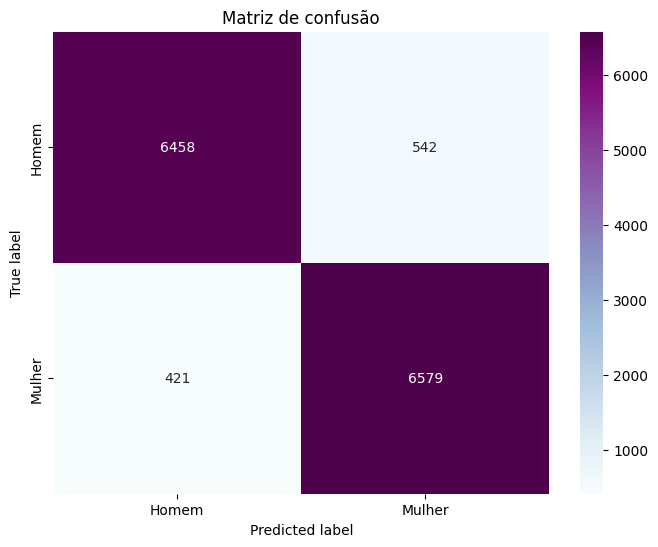

In [34]:
matriz = confusion_matrix(labels_teste, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='BuPu', xticklabels=['Homem', 'Mulher'], yticklabels=['Homem', 'Mulher'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Matriz de confusão')
plt.show()

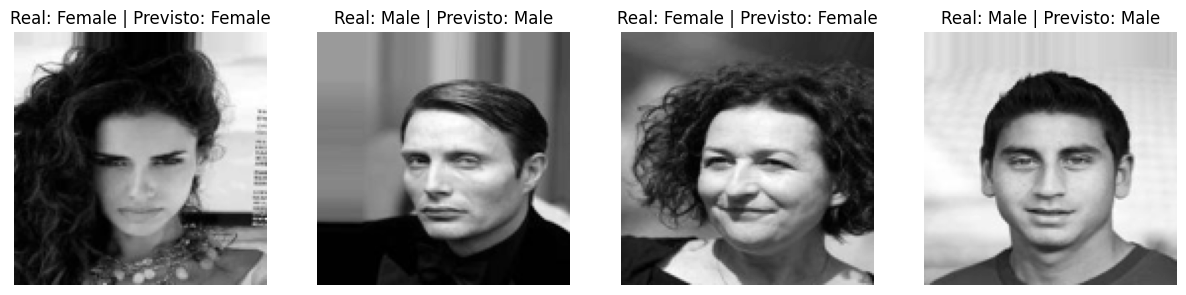

In [23]:
num_images = 4

# Selecionar uma amostra aleatória de imagens de teste
indices = np.random.choice(len(images_teste), num_images, replace=False)
sample_images = images_teste[indices]
sample_labels = labels_teste[indices]
sample_predictions = y_pred[indices]

# Configurar o tamanho da figura
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, ax in enumerate(axes):
    img = sample_images[i].squeeze()  # Remove a dimensão do canal extra
    real_label = 'Male' if sample_labels[i] == 0 else 'Female'
    predicted_label = 'Male' if sample_predictions[i] == 0 else 'Female'
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Real: {real_label} | Previsto: {predicted_label}')
    ax.axis('off')

plt.show()


---
# Salvando modelo

In [10]:
joblib.dump(mlp, 'mlp_model.pkl')

['mlp_model.pkl']

In [22]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']